In [1]:
import rasterio
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
# --- New Imports for PCA and Scaling ---
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
# ---------------------------------------

# Suppress common runtime warnings (e.g., from NaN comparisons)
warnings.filterwarnings('ignore', category=RuntimeWarning)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# --- Configuration ---
BASE_DIR = Path('.')
REGIONS = ["CONUS", "HI"]

# Static WRF-Hydro Parameters only (based on the file list provided)
PARAMETER_NAMES = [
    "ISLTYP",
    "IVGTYP",
    "bexp_soil_layers_stag=1",
    "cwpvt",
    "dksat_soil_layers_stag=1",
    "mfsno",
    "mp",
    "refkdt",
    "slope",
    "smcmax_soil_layers_stag=1",
    "smcwlt_soil_layers_stag=1",
    "vcmx25"
]

# Dictionary to hold the raw pandas Series data for easy debugging
data_series_dict = {}

print(f"Total static parameters to analyze: {len(PARAMETER_NAMES)}")
print(f"Parameter list: {PARAMETER_NAMES}")

Total static parameters to analyze: 12
Parameter list: ['ISLTYP', 'IVGTYP', 'bexp_soil_layers_stag=1', 'cwpvt', 'dksat_soil_layers_stag=1', 'mfsno', 'mp', 'refkdt', 'slope', 'smcmax_soil_layers_stag=1', 'smcwlt_soil_layers_stag=1', 'vcmx25']


In [3]:
def load_and_clean_data(parameter_name: str, region: str) -> pd.Series:
    """
    Loads a GeoTIFF file, extracts the data, handles NoData values,
    and returns a pandas Series of valid, flattened values.
    """
    filepath = BASE_DIR / f"{parameter_name}_{region}.tif"
    print(f"\n--- Loading {region} ({parameter_name}) ---")
    
    if not filepath.exists():
        print(f"⚠️ Error: File not found at {filepath}. Returning empty Series.")
        return pd.Series(dtype='float64')

    try:
        with rasterio.open(filepath) as src:
            # 1. Read the raster data as a NumPy array
            data = src.read(1)
            
            # 2. Identify the NoData value
            nodata_value = src.nodata
            
            # 3. Flatten the 2D array to 1D
            flat_data = data.flatten()
            
            # 4. Filter out NoData values and NaNs
            if nodata_value is not None and not np.isnan(nodata_value):
                # Filter out the specific NoData marker
                valid_data = flat_data[flat_data != nodata_value]
            else:
                # If nodata is None or NaN, start with the full dataset
                valid_data = flat_data
                
            # Filter out any lingering IEEE floating point NaNs
            valid_data = valid_data[~np.isnan(valid_data)]
            
            # 5. Print critical diagnostic information
            total_pixels = flat_data.size
            null_pixels = total_pixels - valid_data.size
            print(f"File: {filepath.name}")
            print(f"Total Pixels (grid size): {total_pixels}")
            print(f"Valid Data Points (non-null): {valid_data.size}")
            
            # 6. Return as a pandas Series
            return pd.Series(valid_data, name="Parameter Value")

    except rasterio.RasterioIOError as e:
        print(f"⚠️ Error reading file {filepath}: {e}")
        return pd.Series(dtype='float64')
    except Exception as e:
        print(f"⚠️ An unexpected error occurred: {e}")
        return pd.Series(dtype='float64')

In [4]:
master_df_list = []

print("--- Starting Data Loading ---")
for param_name in PARAMETER_NAMES:
    
    for region in REGIONS:
        data_series = load_and_clean_data(param_name, region)
        
        # --- CRITICAL DIAGNOSTIC PRINT (Verification of correct count) ---
        current_count = len(data_series)
        print(f"-> Series length returned for {region}: {current_count}")
        # ---------------------------------
        
        # Create a temporary DataFrame for concatenation.
        df_temp = pd.DataFrame({
            'Parameter Value': data_series,
            'Region': region,
            'Parameter': param_name
        })
        
        # To ensure pivoting works, the index must represent the PIXEL ID.
        # We assume that all parameters for a given region have the same length and alignment.
        
        # 1. Create a local index based on the number of pixels in this series
        df_temp['Pixel_Index'] = np.arange(current_count)
        
        # 2. Create the global unique pixel identifier *immediately*
        df_temp['Pixel_ID'] = df_temp['Region'].astype(str) + '_' + df_temp['Pixel_Index'].astype(str)
        
        # Append the temporary DataFrame to the list
        master_df_list.append(df_temp)


# --- Final Concatenation ---
# Concatenate all DataFrames in the list into the final master_df
master_df = pd.concat(master_df_list, ignore_index=True)

print("\n--- Data Loading Complete ---")
print(f"Total entries loaded into master_df: {len(master_df)}")
print("\nMaster DataFrame Head (Verifying Pixel_ID):")
print(master_df.head())

--- Starting Data Loading ---

--- Loading CONUS (ISLTYP) ---
File: ISLTYP_CONUS.tif
Total Pixels (grid size): 17694720
Valid Data Points (non-null): 17694720
-> Series length returned for CONUS: 17694720

--- Loading HI (ISLTYP) ---
File: ISLTYP_HI.tif
Total Pixels (grid size): 230100
Valid Data Points (non-null): 230100
-> Series length returned for HI: 230100

--- Loading CONUS (IVGTYP) ---
File: IVGTYP_CONUS.tif
Total Pixels (grid size): 17694720
Valid Data Points (non-null): 17694720
-> Series length returned for CONUS: 17694720

--- Loading HI (IVGTYP) ---
File: IVGTYP_HI.tif
Total Pixels (grid size): 230100
Valid Data Points (non-null): 230100
-> Series length returned for HI: 230100

--- Loading CONUS (bexp_soil_layers_stag=1) ---
File: bexp_soil_layers_stag=1_CONUS.tif
Total Pixels (grid size): 17694720
Valid Data Points (non-null): 17694720
-> Series length returned for CONUS: 17694720

--- Loading HI (bexp_soil_layers_stag=1) ---
File: bexp_soil_layers_stag=1_HI.tif
Total Pi

In [5]:
# Group by both Parameter and Region to quantify the distribution of each
statistics_df = master_df.groupby(['Parameter', 'Region'])['Parameter Value'].agg([
    'count',
    'min',
    'max',
    'mean',
    'median',
    'std',
    lambda x: x.quantile(0.25), # Q1
    lambda x: x.quantile(0.75)  # Q3
]).rename(columns={'<lambda_0>': 'Q1 (25th)', '<lambda_1>': 'Q3 (75th)'})

print("\n--- Full Descriptive Statistics ---")

# Format the output using scientific notation for easier comparison of values
with pd.option_context('display.float_format', '{:.4e}'.format, 'display.max_rows', None):
    print(statistics_df)

print("\n\nNext Steps Analysis:")
print("1. Ensure all 'count' values for HI are correct (i.e., significantly smaller than 17,694,720).")
print("2. The large differences in 'min/max/std' (e.g., dksat vs. smcmax) confirm the need for data standardization (Z-score scaling or similar) before running PCA.")
print("3. Check for low-variance parameters (std near zero), which may be discarded if they don't contribute to separation between CONUS and HI.")



--- Full Descriptive Statistics ---
                                     count        min        max       mean  \
Parameter                 Region                                              
ISLTYP                    CONUS   17694720 1.0000e+00 1.6000e+01 7.9142e+00   
                          HI        230100 1.0000e+00 1.4000e+01 1.3507e+01   
IVGTYP                    CONUS   17694720 1.0000e+00 2.3000e+01 1.1505e+01   
                          HI        230100 1.0000e+00 2.5000e+01 1.5662e+01   
bexp_soil_layers_stag=1   CONUS   17694720 0.0000e+00 2.1945e+01 4.7613e+00   
                          HI        230100 0.0000e+00 2.0417e+01 4.1977e-01   
cwpvt                     CONUS   17694720 9.0016e-02 3.6000e-01 1.9160e-01   
                          HI        230100 9.0175e-02 3.4086e-01 1.8102e-01   
dksat_soil_layers_stag=1  CONUS   17694720 0.0000e+00 1.4100e-03 5.2105e-06   
                          HI        230100 0.0000e+00 3.3772e-05 8.0059e-07   
mfsno          

In [6]:
statistics_df

count       min         max  \
Parameter                 Region                                   
ISLTYP                    CONUS   17694720  1.000000   16.000000   
                          HI        230100  1.000000   14.000000   
IVGTYP                    CONUS   17694720  1.000000   23.000000   
                          HI        230100  1.000000   25.000000   
bexp_soil_layers_stag=1   CONUS   17694720  0.000000   21.944988   
                          HI        230100  0.000000   20.417421   
cwpvt                     CONUS   17694720  0.090016    0.359996   
                          HI        230100  0.090175    0.340863   
dksat_soil_layers_stag=1  CONUS   17694720  0.000000    0.001410   
                          HI        230100  0.000000    0.000034   
mfsno                     CONUS   17694720  0.501068    3.999983   
                          HI        230100  2.500000    2.500000   
mp                        CONUS   17694720  3.600006   12.599991   
                          HI        230100  3.610579   12.409594   
refkdt                    CONUS   17694720  2.000000    2.000000   
                          HI        230100  1.300000    1.300000   
slope                     CONUS   17694720  0.000060    0.999706   
                          HI        230100  0.006881    0.979687   
smcmax_soil_layers_stag=1 CONUS   17694720  0.160315    1.000000   
                          HI        230100  0.340831    1.000000   
smcwlt_soil_layers_stag=1 CONUS   17694720  0.000000    0.138000   
                          HI        230100  0.000000    0.138000   
vcmx25                    CONUS   17694720  0.000000  111.999924   
                          HI        230100  0.000000  106.494560   

                                          mean     median        std  \
Parameter                 Region                                       
ISLTYP                    CONUS   7.914188e+00   6.000000   4.669120   
                          HI      1.350686e+01  14.000000   1.886370   
IVGTYP                    CONUS   1.150521e+01  14.000000   4.998264   
                          HI      1.566190e+01  16.000000   1.874302   
bexp_soil_layers_stag=1   CONUS   4.761289e+00   5.250000   3.896049   
                          HI      4.197701e-01   0.000000   1.874614   
cwpvt                     CONUS   1.916018e-01   0.180000   0.064834   
                          HI      1.810246e-01   0.180000   0.021614   
dksat_soil_layers_stag=1  CONUS   5.210508e-06   0.000002   0.000015   
                          HI      8.005869e-07   0.000000   0.000004   
mfsno                     CONUS   2.024792e+00   2.000000   0.583177   
                          HI      2.500000e+00   2.500000   0.000000   
mp                        CONUS   9.128572e+00   9.000000   1.743182   
                          HI      8.976944e+00   9.000000   0.660173   
refkdt                    CONUS   2.000000e+00   2.000000   0.000000   
                          HI      1.300000e+00   1.300000   0.000000   
slope                     CONUS   1.174029e-01   0.100000   0.154290   
                          HI      3.246046e-01   0.330000   0.062123   
smcmax_soil_layers_stag=1 CONUS   6.178265e-01   0.468000   0.257899   
                          HI      9.636190e-01   1.000000   0.132459   
smcwlt_soil_layers_stag=1 CONUS   4.609779e-02   0.047000   0.038438   
                          HI      5.739618e-03   0.000000   0.021789   
vcmx25                    CONUS   3.764313e+01  40.931717  30.195352   
                          HI      2.725408e+00   0.000000  11.653403   

                                  Q1 (25th)  Q3 (75th)  
Parameter                 Region                        
ISLTYP                    CONUS    4.000000  14.000000  
                          HI      14.000000  14.000000  
IVGTYP                    CONUS    8.000000  16.000000  
                          HI      16.000000  16.000000  
bexp_soil_layers_stag=1   CONUS    0.000000   7.65289

In [7]:
print("\n--- 6. Data Preprocessing and PCA Execution ---")

# --- Step 6.1: Pivot to Wide Format (Features as Columns, Pixels as Rows) ---
# FIX: Use the 'Pixel_ID' column as the index for pivoting.
wide_df = master_df.pivot(index='Pixel_ID', columns='Parameter', values='Parameter Value')

# The 'Region' label is now a separate column in master_df. We extract it based on the Pixel_ID.
# Since Region is part of the Pixel_ID, we can simply extract it.
wide_df['Region'] = wide_df.index.str.split('_').str[0]


# Separate features (X) from the target (Region)
X = wide_df.drop(columns=['Region'])
y = wide_df['Region']

# --- Step 6.2: Filter Low-Variance Columns and Apply Transformation ---
# Identify columns with standard deviation near zero (e.g., refkdt)
low_variance_cols = X.std()[X.std() < 1e-6].index.tolist()
if low_variance_cols:
    X = X.drop(columns=low_variance_cols)
    print(f"Filtered low-variance columns (removed from PCA): {low_variance_cols}")

# Apply log transformation to dksat_soil_layers_stag=1 (Hydraulic Conductivity)
# Use log(1+x) to handle the numerous zero values safely.
log_transform_col = 'dksat_soil_layers_stag=1'
if log_transform_col in X.columns:
    X[log_transform_col] = np.log1p(X[log_transform_col])
    print(f"Applied log(1+x) transformation to: {log_transform_col}")

# --- Step 6.3: Standardization (Crucial for PCA) ---
# All features must be on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# --- Step 6.4: Execute PCA ---
# We only need the first principal component (n_components=1)
pca = PCA(n_components=1)
pca.fit(X_scaled)

# Project the data onto PC1
X_pca = pca.transform(X_scaled)

# Add the Principal Component 1 scores back to the dataframe
wide_df['PC1'] = X_pca[:, 0]

# Print Variance Explained
explained_variance = pca.explained_variance_ratio_[0]
print(f"\nVariance Explained by PC1: {explained_variance * 100:.2f}%")
print("PCA execution complete. Ready for plotting.")


--- 6. Data Preprocessing and PCA Execution ---
Applied log(1+x) transformation to: dksat_soil_layers_stag=1

Variance Explained by PC1: 37.85%
PCA execution complete. Ready for plotting.



--- 7. PC1 Distribution Plot ---


/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_4197/3858745624.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,100])


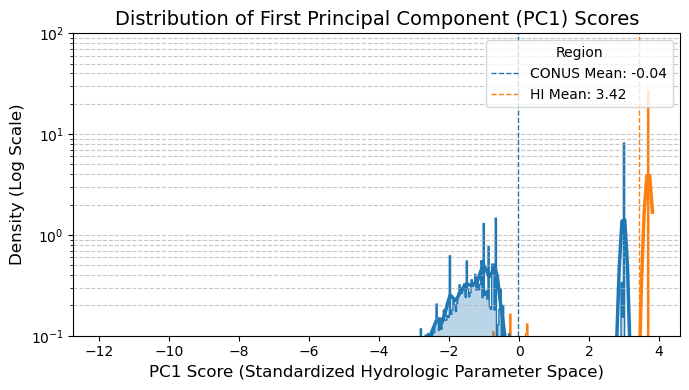


--- Interpretation Guidance ---
PC1 explains 37.85% of the total variance in the parameter space.
The primary separation between the CONUS and Hawaii domains is captured along this axis.
To interpret PC1, look at the correlation between the original parameters and the PC1 score:

Top 5 Loadings (Parameters most contributing to the separation):
Parameter
smcmax_soil_layers_stag=1    0.442281
vcmx25                       0.420505
bexp_soil_layers_stag=1      0.418003
smcwlt_soil_layers_stag=1    0.394018
ISLTYP                       0.386170
dtype: float64


In [18]:
print("\n--- 7. PC1 Distribution Plot ---")

plt.figure(figsize=(7, 4))

# Plot the distribution of PC1 colored by region
sns.histplot(
    data=wide_df,
    x='PC1',
    hue='Region',
    stat='density',
    common_norm=False,
    kde=True,
    element='step',
    palette={'CONUS': '#1f77b4', 'HI': '#ff7f0e'},
    line_kws={'linewidth': 2.5},
    alpha=0.3,
)

# --- FIX: Apply log scale to the Y-axis and set lower limit ---
plt.yscale('log')
plt.ylim(0.1, None) # Set floor for density at 0.1
# -----------------------------------------------------------

# Add key statistical annotations
conus_mean = wide_df[wide_df['Region'] == 'CONUS']['PC1'].mean()
hi_mean = wide_df[wide_df['Region'] == 'HI']['PC1'].mean()

plt.axvline(conus_mean, color='#1f77b4', linestyle='--', linewidth=1, label=f'CONUS Mean: {conus_mean:.2f}')
plt.axvline(hi_mean, color='#ff7f0e', linestyle='--', linewidth=1, label=f'HI Mean: {hi_mean:.2f}')


plt.title('Distribution of First Principal Component (PC1) Scores', fontsize=14)
plt.xlabel('PC1 Score (Standardized Hydrologic Parameter Space)', fontsize=12)
plt.ylabel('Density (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7, which="both") # Add "which=both" for log scale
plt.legend(title='Region', loc='upper right')
plt.ylim([0,100])
plt.tight_layout()
plt.show()

# --- PC1 Interpretation Guidance ---
print("\n--- Interpretation Guidance ---")
print(f"PC1 explains {explained_variance * 100:.2f}% of the total variance in the parameter space.")
print("The primary separation between the CONUS and Hawaii domains is captured along this axis.")
print("To interpret PC1, look at the correlation between the original parameters and the PC1 score:")
pc1_loadings = pd.Series(pca.components_[0], index=X.columns)
print("\nTop 5 Loadings (Parameters most contributing to the separation):")
print(pc1_loadings.abs().sort_values(ascending=False).head(5))




--- 8. Loading and Plotting Atmospheric Conditions ---


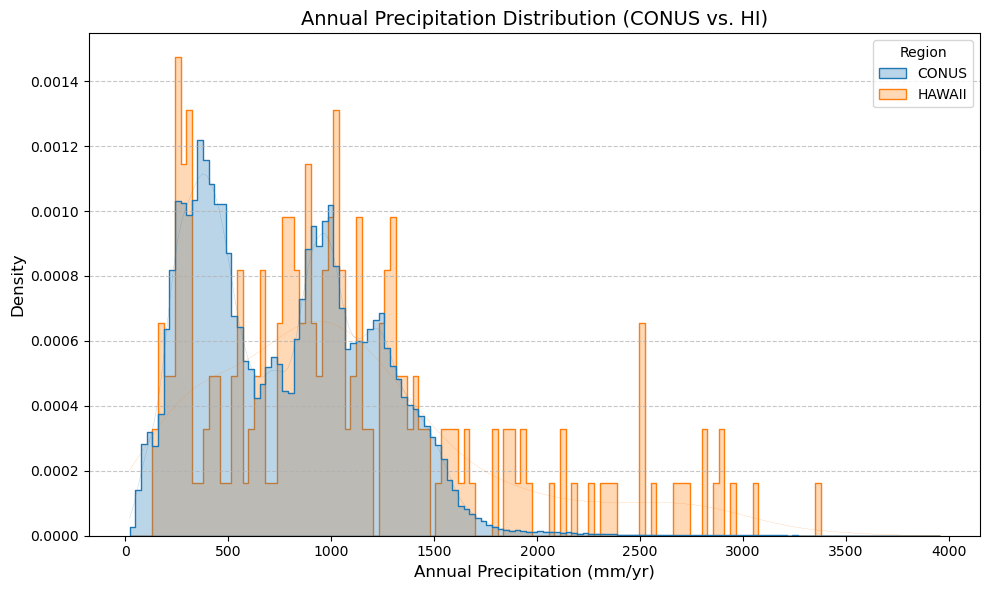

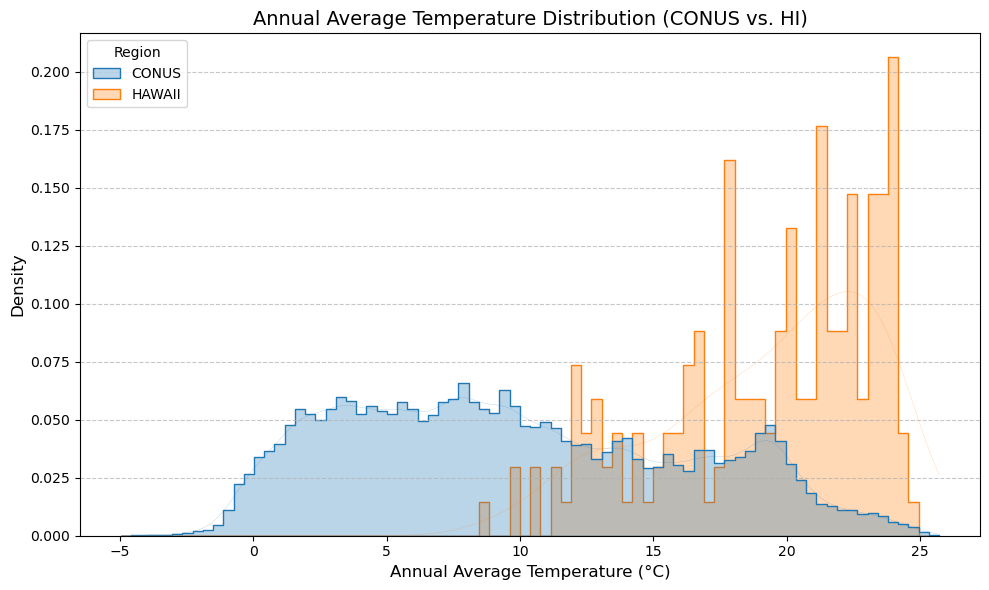


Climate plot generation complete.


In [17]:
# List of CSV files exported from GEE
CLIMATE_FILES = [
    "Annual_Precipitation_CONUS_data.csv",
    "Annual_Precipitation_HAWAII_data.csv",
    "Annual_Temperature_CONUS_data.csv",
    "Annual_Temperature_HAWAII_data.csv"
]

climate_df_list = []

print("\n--- 8. Loading and Plotting Atmospheric Conditions ---")
for file_name in CLIMATE_FILES:
    filepath = BASE_DIR / file_name
    
    if not filepath.exists():
        print(f"⚠️ Warning: Climate file not found: {file_name}. Skipping.")
        continue
    
    # 1. Load the CSV
    df = pd.read_csv(filepath)
    
    # 2. Determine Region and Parameter from file name
    region = file_name.split('_')[-2]
    
    # 3. Rename and select value column, and determine correct Parameter label (FIXED LOGIC)
    if 'annual_prcp' in df.columns:
        value_col = 'annual_prcp'
        parameter_label = 'Precipitation'
        unit = ' (mm/yr)'
    elif 'annual_temp_C' in df.columns:
        value_col = 'annual_temp_C'
        parameter_label = 'Temperature'
        unit = ' (°C)'
    else:
        print(f"Could not identify parameter column in {file_name}. Skipping.")
        continue
    
    df_temp = pd.DataFrame({
        'Parameter Value': df[value_col],
        'Region': region,
        'Parameter': parameter_label, # Use the correctly derived label
        'Unit': unit
    })
    
    climate_df_list.append(df_temp)

if not climate_df_list:
    print("No climate data loaded. Cannot generate plots.")
else:
    climate_master_df = pd.concat(climate_df_list, ignore_index=True)
    
    # --- Generate Plots ---
    
    # A. Precipitation Plot (Filter now uses 'Precipitation')
    prcp_df = climate_master_df[climate_master_df['Parameter'] == 'Precipitation']
    
    if not prcp_df.empty and prcp_df['Region'].nunique() > 1:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=prcp_df,
            x='Parameter Value',
            hue='Region',
            stat='density',
            common_norm=False,
            kde=True,
            element='step',
            palette={'CONUS': '#1f77b4', 'HAWAII': '#ff7f0e'},
            line_kws={'linewidth': 0.1},
            alpha=0.3,
        )
#        plt.xscale('log') # Precipitation is naturally log-distributed
        plt.title('Annual Precipitation Distribution (CONUS vs. HI)', fontsize=14)
        plt.xlabel('Annual Precipitation (mm/yr)', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        # FIX: Removed plt.legend() call to resolve UserWarning
        # Seaborn automatically places the legend when 'hue' is used
        plt.grid(axis='y', linestyle='--', alpha=0.7, which="both")
        plt.tight_layout()
        plt.show()
    else:
        print("Precipitation plot skipped: Data is empty or only one region found.")


    # B. Temperature Plot (Filter now uses 'Temperature' and handles empty data)
    temp_df = climate_master_df[climate_master_df['Parameter'] == 'Temperature']

    if not temp_df.empty and temp_df['Region'].nunique() > 1:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=temp_df,
            x='Parameter Value',
            hue='Region',
            stat='density',
            common_norm=False,
            kde=True,
            element='step',
            palette={'CONUS': '#1f77b4', 'HAWAII': '#ff7f0e'},
            line_kws={'linewidth': 0.1},
            alpha=0.3,
        )
        # Temperature is normally distributed, no log scale needed
        plt.title('Annual Average Temperature Distribution (CONUS vs. HI)', fontsize=14)
        plt.xlabel('Annual Average Temperature (°C)', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        # FIX: Removed plt.legend() call to resolve UserWarning
        # Seaborn automatically places the legend when 'hue' is used
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Temperature plot skipped: Data is empty or only one region found.")

    print("\nClimate plot generation complete.")